In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from tqdm import tqdm

sns.set(rc = {"figure.figsize":(16, 9)})

In [24]:
df = pd.read_csv("Data.csv")

vols = np.array(df["Volume"])
vols.sort()

changes = np.array(df["AskAfter"] - df["AskBefore"])
changes.sort()

dfAskT30 = df[df["AskAfter"] - df["AskBefore"] > 0.11]
dfVolT30 = df[df["Volume"] > 9e5]

NumsVol = np.array(dfVolT30["Unnamed: 0"])
NumsAsk = np.array(dfAskT30["Unnamed: 0"])

In [25]:
filename = "../data preparing/USD000UTSTOM_l2_ask.txt"

In [5]:
def next_asks(filename, mem_len, deal_number):
    a = 0
    file = open(filename, 'r')

    asks = np.full((mem_len + 1, 2), 0, dtype=float)

    number = 0  

    try:
        line = next(file)
    except:
        print("cant read even one line")
        file.close()
        return []  
       
    while True:
        try:
            line = next(file)
        except:
            break   

        if line[0] != "P":
            # print(line)
            line = line.split()
            price = float(line[2][:-1])
            time = sum(np.array(line[0].split(":")).astype(float) * np.array([3600, 60, 1])) - 36000
        else:
            # print(line)
            # print(number)
            if number == deal_number:
                line = line.split()
                
                asks[0][0] = price
                asks[0][1] = time    
                
                for j in range(1, mem_len + 1):
                    try:
                        line = next(file)
                    except:
                        break

                    if line[0] == "P":
                        line = line.split()
                        a += 1
                        continue    

                    line = line.split()
                    if(abs(float(line[2][:-1])) < 1e-5):
                        print(line)
                    asks[j - a][0] = float(line[2][:-1])
                    asks[j - a][1] = sum(np.array(line[0].split(":")).astype(float) * np.array([3600, 60, 1])) - 36000
                return asks

            number += 1 
    file.close()
    return asks

In [94]:
def plot_asks(filename, mem_len, deal_num):
    asks = next_asks(filename, mem_len, deal_num)
    fb = np.where(asks == 0)[0][0]
    print(fb)
    asks = asks[:fb]
    plt.plot(asks[:, 1], asks[:,0])

In [45]:
def OWdynamics(steady_state, volume, kappa, rho):
    def OW(t):
        return steady_state + volume * kappa * np.exp(- rho * t / 1000)
    
    return OW

In [33]:
asks = next_asks(filename, 500000, 0)
fb = np.where(asks == 0)[0][0]
print(fb)
asks = asks[:fb]

484654


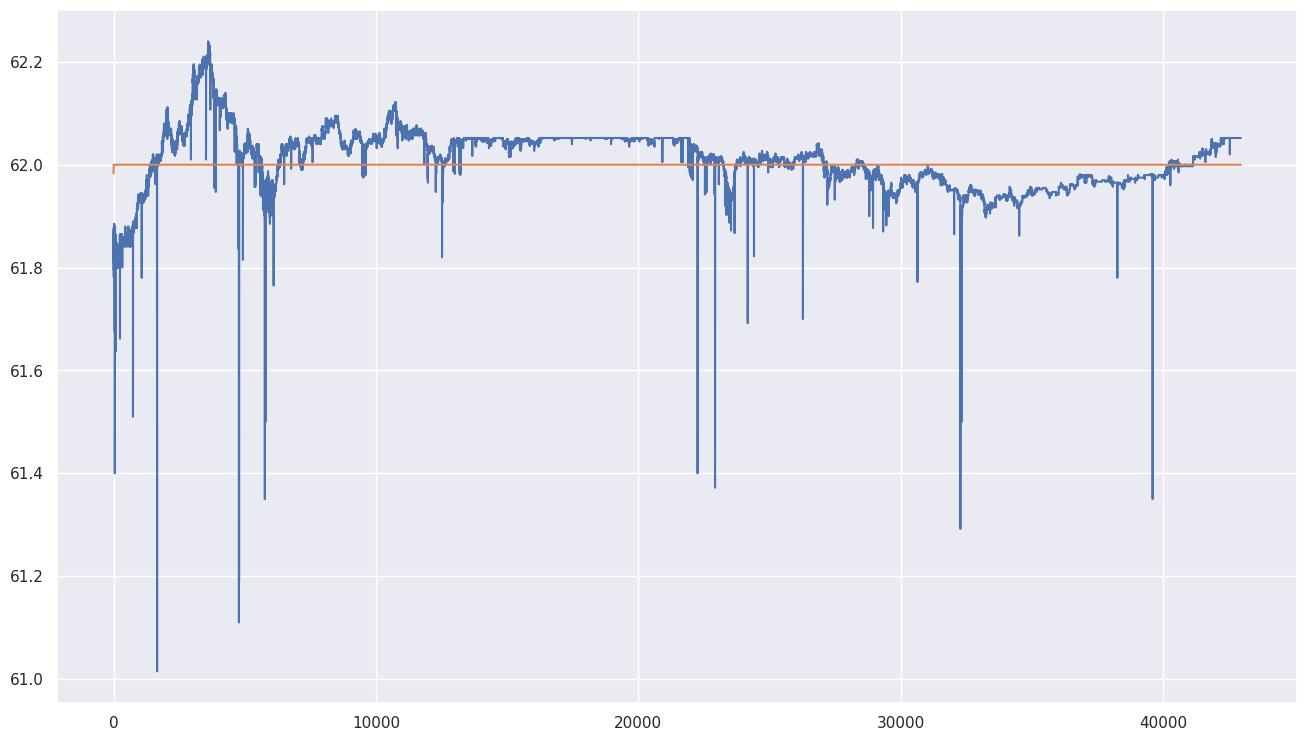

In [46]:
plt.plot(asks[:, 1], asks[:,0])

OWf =  OWdynamics(62., 10000, -5.707670757249037, 15033.62964678484)

plt.plot(asks[:, 1], OWf(asks[:, 1]))

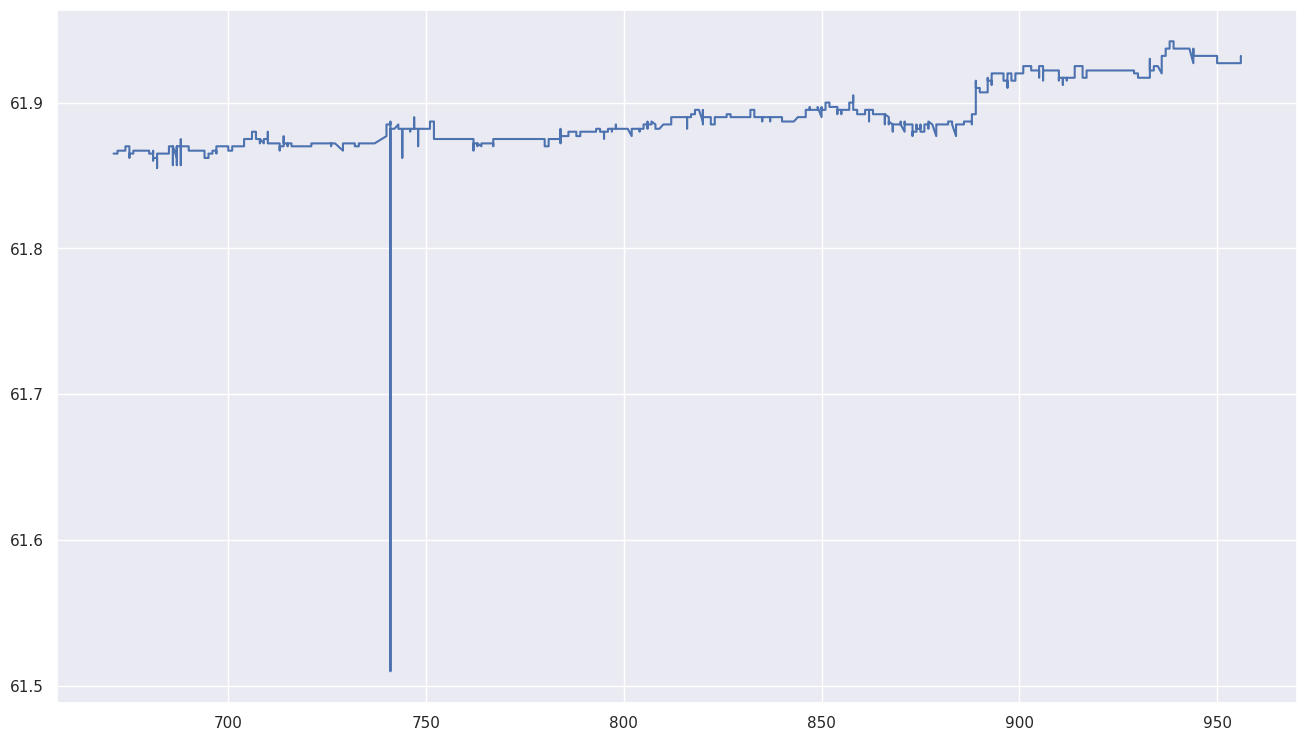

In [31]:
a = 15000

pasks = asks[a:a+10000]
plt.plot(pasks[:, 1], pasks[:,0])